In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import scipy
import pandas as pd
from datacleaner import autoclean, autoclean_cv
import shap
from sklearn.metrics import r2_score
import matplotlib as plt

In [3]:
# load training X
X_train = pd.read_csv("Aut_PC1_T7_X_train.csv")
# X = pd.read_csv("train_all.csv")
y_train = pd.read_csv("Aut_PC1_T7_y_train.csv")
#add y to x for cleaning together
X_train['y'] = y_train

# load Test X
X_test = pd.read_csv("Aut_PC1_T7_X_test_cut.csv")
# X = pd.read_csv("train_all.csv")
y_test = pd.read_csv("Aut_PC1_T7_y_test_cut.csv")
#add y to x for cleaning together
X_test['y'] = y_test

# clean datasets !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
autoclean_cv(X_train, X_test)
#X_train, X_test = autoclean_cv(X_train, X_test)

#separate y from x after cleaning
y_train = X_train["y"]
X_train = X_train.drop(["y"], axis=1)

y_test = X_test["y"]
X_test = X_test.drop(["y"], axis=1)


data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
data_test_dmatrix = xgb.DMatrix(data=X_test,label=y_test)

In [4]:
X_all = pd.concat([X_train,X_test])
y_all = pd.concat([y_train,y_test])
data_dmatrix_all = xgb.DMatrix(data=X_all,label=y_all)

In [5]:
# Instantiate a XGBRegressor with the hyperparameters found in optimization
clf_best = xgb.XGBRegressor(n_estimators = 8,
                            colsample_bytree=0.84,
                           learning_rate = 0.546,
                            max_depth = 6,
                            min_child_weight = 5,
                            subsample = 0.724,
                           gamma = 0.427,
                           reg_lambda = 0.59,
                          reg_alpha = 0.67, booster='gbtree',objective='reg:linear')

# Fit the regressor to the training data
clf_best.fit(X_train, y_train)

# Predict the test data
test_pred = clf_best.predict(X_test)

# correlate the predicted iHRV with the true iHRV
scipy.stats.spearmanr(test_pred, y_test)

SpearmanrResult(correlation=0.5415418341249544, pvalue=1.5475164727142502e-06)

In [6]:
scipy.stats.shapiro(y_test)

ShapiroResult(statistic=0.9844793081283569, pvalue=0.5496021509170532)

In [7]:
# Predict the entire dataset (train+test)
all_pred = clf_best.predict(X_all)
scipy.stats.spearmanr(all_pred, y_all)

SpearmanrResult(correlation=0.7181899106259297, pvalue=1.0822579732134585e-22)

In [8]:
scipy.stats.shapiro(all_pred)

ShapiroResult(statistic=0.9926350116729736, pvalue=0.7091666460037231)

In [9]:
# 10 fold cross-validation
from sklearn.model_selection import cross_val_predict
train_pred = cross_val_predict(clf_best, X_train, y_train, cv=10)
scipy.stats.spearmanr(y_train, train_pred)

SpearmanrResult(correlation=0.27509185042733975, pvalue=0.025385988209342333)

In [10]:
# Other performance metrics
from sklearn import metrics
test_pred = clf_best.predict(X_test)
train_pred = cross_val_predict(clf_best, X_train, y_train, cv=10)
#train_pred = clf_best.predict(X_train)
print('TEST')
print('Test MAE:', metrics.mean_absolute_error(y_test, test_pred))  
print('Test MSE:', metrics.mean_squared_error(y_test, test_pred))  
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, test_pred)))
yIQR = scipy.stats.iqr(y_test, interpolation = 'midpoint')
print('Test yIQR:', yIQR)
print('Test iqrRMSE:', np.sqrt(metrics.mean_squared_error(y_test, test_pred))/yIQR)
print('Test meanRMSE:', np.sqrt(metrics.mean_squared_error(y_test, test_pred))/np.mean(y_test))
print('Test MAPE:', np.mean(np.abs((y_test - test_pred) / y_test)) * 100)
print('Test R^2:', clf_best.score(X_test, y_test))
print('Test SpearmanR:', scipy.stats.spearmanr(test_pred, y_test)[0])

print('CV Train')
print('CV Train MAE:', metrics.mean_absolute_error(y_train, train_pred))  
print('CV Train MSE:', metrics.mean_squared_error(y_train, train_pred))  
print('CV Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
yIQR = scipy.stats.iqr(y_train, interpolation = 'midpoint')
print('CV Train yIQR:', yIQR)
print('CV Train iqrRMSE:', np.sqrt(metrics.mean_squared_error(y_train, train_pred))/yIQR)
print('CV Train meanRMSE:', np.sqrt(metrics.mean_squared_error(y_train, train_pred))/np.mean(y_train))
print('CV MAPE:', np.mean(np.abs((y_train - train_pred) / y_train)) * 100)
print('CV Train R^2:', clf_best.score(X_train, y_train))
print('CV Train SpearmanR:', scipy.stats.spearmanr(train_pred, y_train)[0])

TEST
Test MAE: 1.020039601229239
Test MSE: 1.5636245699149762
Test RMSE: 1.2504497470570244
Test yIQR: 2.086
Test iqrRMSE: 0.5994485843993406
Test meanRMSE: -16.119763203537545
Test MAPE: 105.53558810885471
Test R^2: 0.2816399561049796
Test SpearmanR: 0.5415418341249544
CV Train
CV Train MAE: 1.1211637348810832
CV Train MSE: 1.913619849890249
CV Train RMSE: 1.3833364919245965
CV Train yIQR: 1.8895
CV Train iqrRMSE: 0.7321177517462802
CV Train meanRMSE: -5.704622950090812
CV MAPE: 229.61793135404264
CV Train R^2: 0.8397626163299418
CV Train SpearmanR: 0.2750918504273398


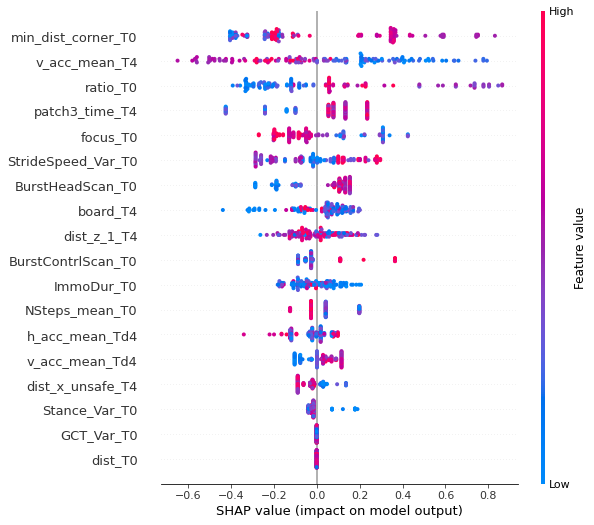

In [11]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf_best)
shap_values_all = explainer.shap_values(X_all)
# summarize the effects of all the features
shap.summary_plot(shap_values_all, X_all)

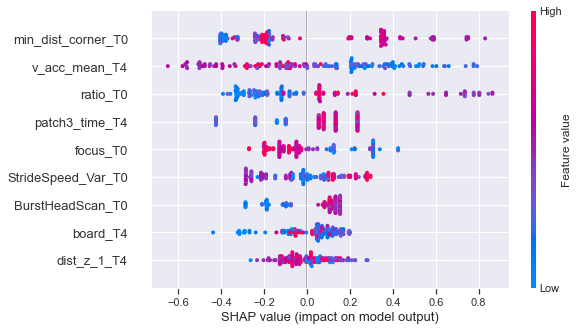

In [32]:
import matplotlib as plt
shap_values_all = explainer.shap_values(X_all)
# summarize the effects of all the features
shap.summary_plot(shap_values_all, X_all,max_display=9, show=False)
plt.pyplot.savefig('Fig2Ea.pdf')
df_shap_values = pd.DataFrame(shap_values_all, index=X_all.index, columns=X_all.columns)
df_shap_values.to_csv('Fig2Ea_shap.csv')
X_all.to_csv('Fig2Eb_shap.csv')

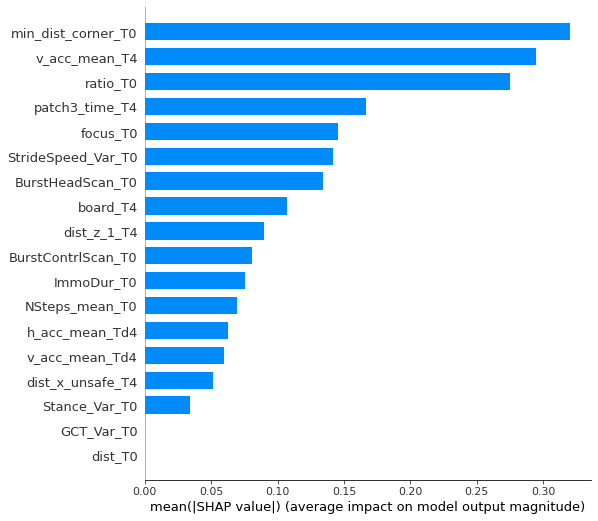

In [13]:
shap.summary_plot(shap_values_all, X_all, plot_type="bar")

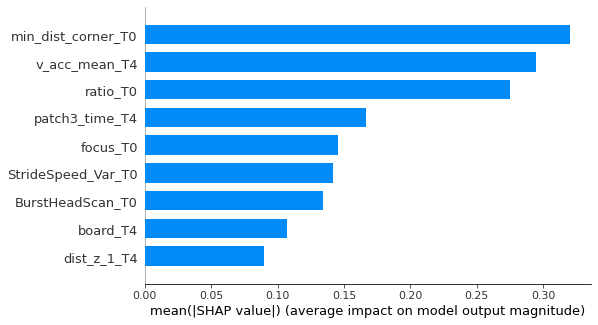

In [14]:
shap.summary_plot(shap_values_all, X_all, plot_type="bar",max_display=9, show=False)
plt.pyplot.savefig('Fig2Eb.pdf')

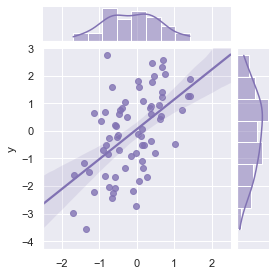

In [15]:
# Test data predictions
import seaborn as sns; sns.set(color_codes=True)
ax = sns.jointplot(x=test_pred, y=y_test,xlim=(-2.5, 2.5), ylim=(-4.3, 3), kind="reg", color="m", truncate = False,height=4)
#ax.ax_joint.set_xlabel('Predicted iHRV', fontsize=20)
#ax.ax_joint.set_ylabel('iHRV', fontsize=20)
plt.pyplot.savefig('Fig2C.pdf',bbox_inches='tight')

In [16]:
fig2c_d = {'Predicted_iHRV': test_pred, 'iHRV': y_test}
fig2c_df = pd.DataFrame(data=fig2c_d)
fig2c_df.to_csv (r'fig2c.csv', index = False, header=True)

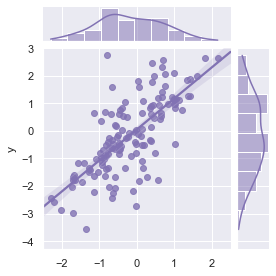

In [17]:
#All data predictions
#sns.set(style="darkgrid")
ax = sns.jointplot(x=all_pred, y=y_all,xlim=(-2.5, 2.5), ylim=(-4.3, 3), kind="reg", color="m", truncate = False,height=4)
#ax.ax_joint.set_xlabel('Predicted iHRV', fontsize=20)
#ax.ax_joint.set_ylabel('iHRV', fontsize=20)
plt.pyplot.savefig('Fig2D.pdf',bbox_inches='tight')

In [18]:
fig2d_d = {'Predicted_iHRV': all_pred, 'iHRV': y_all}
fig2d_df = pd.DataFrame(data=fig2d_d)
fig2d_df.to_csv (r'fig2d.csv', index = False, header=True)

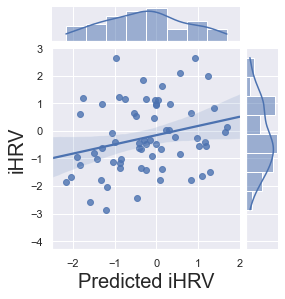

In [19]:
# Train data predictioon with 10-fold cross validation
ax = sns.jointplot(x=train_pred, y=y_train,xlim=(-2.5, 2), ylim=(-4.3, 3), kind="reg", color="b", truncate = False,height=4)
ax.ax_joint.set_xlabel('Predicted iHRV', fontsize=20)
ax.ax_joint.set_ylabel('iHRV', fontsize=20)
plt.pyplot.savefig('FigS3.pdf',bbox_inches='tight')

In [20]:
figS3_d = {'Predicted_iHRV': train_pred, 'iHRV': y_train}
figS3_df = pd.DataFrame(data=figS3_d)
figS3_df.to_csv (r'figS3.csv', index = False, header=True)

In [21]:
def double_heatmap(data1, data2, cbar_label1, cbar_label2,
                   title='', subplot_top=0.86, cmap1='viridis', cmap2='magma', 
                   center1=-1, center2=0, grid_height_ratios=[1,4],
                   figsize=(14,10)):

    fig, (ax,ax2) = plt.pyplot.subplots(nrows=2, figsize=figsize, 
                                 gridspec_kw={'height_ratios':grid_height_ratios})

    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.02, top=subplot_top)

    # heatmap for actual and predicted percentiles
    sns.heatmap(data1, cmap="viridis", ax=ax, xticklabels=False, center=center1,
                cbar_kws={'location':'top', 
                          'use_gridspec':False, 
                          'pad':0.1,
                          'label': cbar_label1})
    ax.set_xlabel('')

    # heatmap of the feature contributions
    sns.heatmap(data2, ax=ax2, xticklabels=False, center=center2, cmap=cmap2,
                cbar_kws={'location':'bottom', 
                          'use_gridspec':False, 
                          'pad':0.07, 
                          'shrink':0.41,
                          'label': cbar_label2})
    ax2.set_ylabel('');
    return fig

In [22]:
shap_values_all_sorted = shap_values_all[:,np.argsort(-clf_best.feature_importances_)]
X_all_sorted = X_all.iloc[:,np.argsort(-clf_best.feature_importances_)]

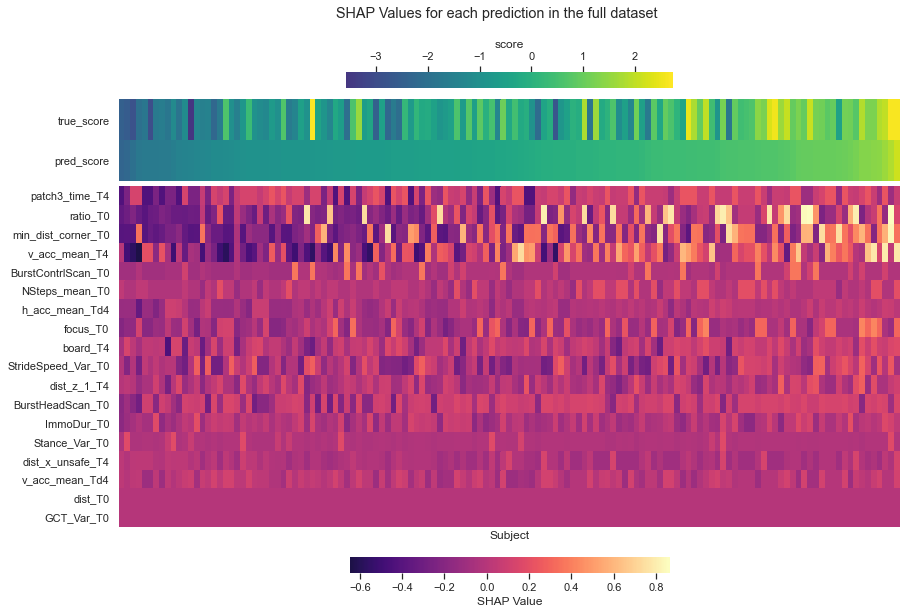

In [25]:
# Plot SHAP values

y_test_and_pred_df = pd.DataFrame(np.column_stack((y_all, all_pred)),
                                  columns=['true_score', 'pred_score'])



test_shap_df = pd.DataFrame(np.column_stack((shap_values_all_sorted, y_test_and_pred_df)),
                            columns= list(X_all_sorted.columns.values) + ['true_score', 
                                                 'pred_score'])

test_shap_df.sort_values('pred_score', inplace=True)

title = 'SHAP Values for each prediction in the full dataset'
fig = double_heatmap(test_shap_df[['true_score', 'pred_score']].T,
                     test_shap_df[list(X_all_sorted.columns.values)].T, 'score', 'SHAP Value',
                     title=title, subplot_top=0.89)
fig.axes[1].set_xlabel('Subject');
plt.pyplot.savefig('FigS12.pdf')

In [26]:
test_shap_df[['true_score', 'pred_score']].to_csv (r'fig12a.csv', index = False, header=True)

In [27]:
test_shap_df[list(X_all_sorted.columns.values)].to_csv (r'fig12b.csv', index = False, header=True)

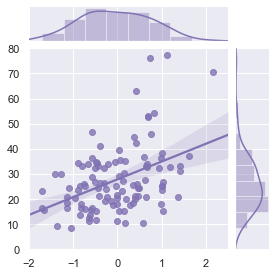

In [138]:
AggroStres_pred = pd.read_csv("NatComm_pred_stress.csv")
#AggroStres_pred = autoclean(AggroStres_pred)
ax = sns.jointplot(x=AggroStres_pred[['Pred']], y=AggroStres_pred[['FullStress_RMSSD']],xlim=(-2, 2.5), ylim=(0, 80),kind="reg", color="m", truncate = False,height=4)
#ax.ax_joint.set_xlabel('Predicted iHRV', fontsize=20)
#ax.ax_joint.set_ylabel('HRV (RMSSD)', fontsize=20)
plt.pyplot.savefig('Fig4c.pdf',bbox_inches='tight')

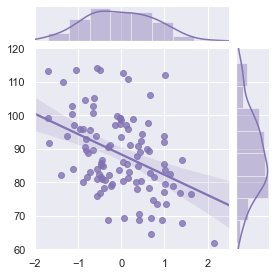

In [128]:
ax = sns.jointplot(x=AggroStres_pred[['Pred']], y=AggroStres_pred[['FullStress_HRBP_median']],xlim=(-2, 2.5), ylim=(60, 120),kind="reg", color="m", truncate = False,height=4)
#ax.ax_joint.set_xlabel('Predicted iHRV', fontsize=20)
#ax.ax_joint.set_ylabel('HR (bpm)', fontsize=20)
plt.pyplot.savefig('Fig4d.pdf',bbox_inches='tight')

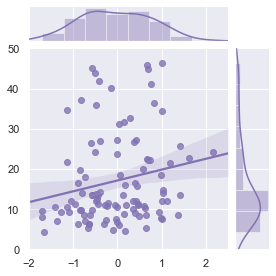

In [126]:
FearCond_phys_pred = pd.read_csv("AllPhysSubsFCUsed.csv")
ax = sns.jointplot(x=FearCond_phys_pred[['PredNov']], y=FearCond_phys_pred[['RMSSD_bp_hab']],xlim=(-2, 2.5), ylim=(0, 50), kind="reg", color="m", truncate = False,height=4)
#ax.ax_joint.set_xlabel('Predicted iHRV', fontsize=20)
#ax.ax_joint.set_ylabel('PRV (RMSSD)', fontsize=20)
plt.pyplot.savefig('Fig4e.pdf',bbox_inches='tight')

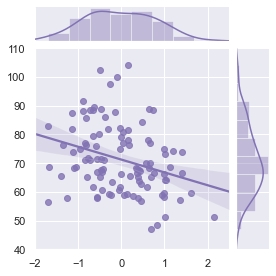

In [127]:
ax = sns.jointplot(x=FearCond_phys_pred[['PredNov']], y=FearCond_phys_pred[['HR_bp_hab']],xlim=(-2, 2.5), ylim=(40, 110),kind="reg", color="m", truncate = False,height=4)
#ax.ax_joint.set_xlabel('Predicted iHRV', fontsize=20)
#ax.ax_joint.set_ylabel('PR (bpm)', fontsize=20)
plt.pyplot.savefig('Fig4f.pdf',bbox_inches='tight')

In [70]:
AggroStres_pred.to_csv (r'AggroStres_pred_clean.csv', index = False, header=True)

In [91]:
scipy.stats.shapiro(FearCond_phys_pred[['RMSSD_bp_hab']])

ShapiroResult(statistic=nan, pvalue=1.0)

In [86]:
scipy.stats.spearmanr(AggroStres_pred[['PredNov']], AggroStres_pred[['FullStress_RMSSD']])

SpearmanrResult(correlation=nan, pvalue=nan)